# Вебинар 5. Ранжирование и Гибридные рекоммендательные системы

# 1. Ранжирование

### 1.1 BPR - Bayesian Personalized Ranking loss

$$loss = \sigma(p^{+} - p^{-})$$

1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p^{+}$, $p^{-}$ --> $p^{+} - p^{-}$
4. loss = $\sigma(p^{+} - p^{-})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

### 1.2 WARP = Weighted Approximate-Rank Pairwise loss
Неплохое [объяснение](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a) на игрушечном примере

$$loss = ln(\frac{K-1}{N})*(p^- - p^+)$$

1. Сэмплируем случайную позитивную пару юзер-item, прогноз модели для этой пары $p^+$
2. Сюмплируем далее до тех пор, пока не найдем негативную пару, гду прогнозная вероятность вероятность $p^-$ > $p^+$
3. K - кол-во сэмплирований (зависит от качества модели!)
4. N - общее количество рекомендаций

**Note**  
loss зависит только от 2ух сэмплированных пар, эмбеддинги только ждя этих пар будут обновлены

In [ ]:
# Case 1
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 4.5

loss(random_seed) = [(3-1) / 10 * (4.5 - 4.3)]

# Case 2 -  модель лучше в этом случае
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 0.5
p_neg_3 = -0.5
p_neg_4 = 2.1
p_neg_5 = 4.5

loss(random_seed) = [(6-1) / 10 * (4.5 - 4.3)]

### Зачем нужно ранжирование? Есть же классификация (предсказание 0 и 1)
- Ранжирование гораздо лучше выбирает топ-k товаров, особенно когда k велико
- Ранжирование позволяет напрямуб ранжировать 5 релевантных юзеру товаров (какой из 5 поставить выше?)

НО:
- При ранжировании невозможно использовать предсказание как вероятность

Прогноз (p) = вероятность  

Мат ож выручки = p * Price

---

# 2. LightFM

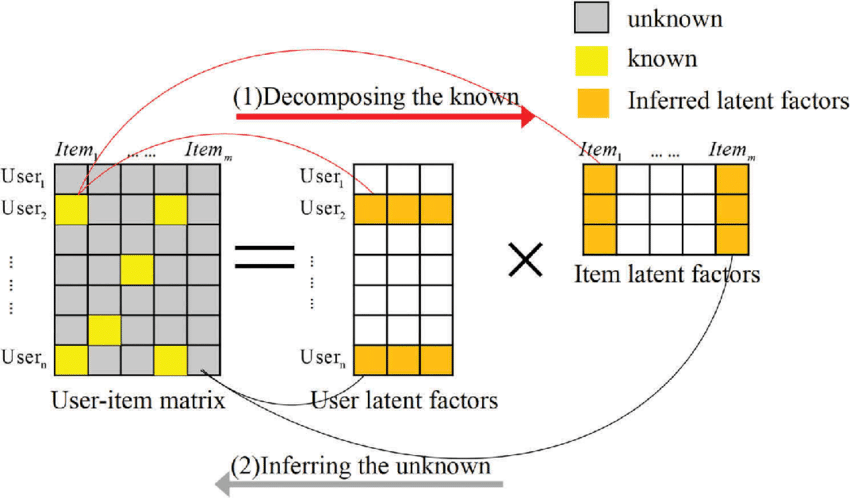

Формула эмбеддинга в ALS (матричной факторизации)

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

Формула в LightFM

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n + \alpha_1 * f_1 + ... + \alpha_k * f_k$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

### Зачем нужны гибридные системы?

*Холодный старт* - ситуация, в которой с товаром/юзером в матрице мало взаимодействий

Холодный страт для товаров - обычно введение нового товара (YouTube, Lamoda, hh.ru)  
Холодный старт для юзера - к нам пришел новый юзер  

Холодного юзера/товар можно описать фичами --> мы больше о нем знаем --> он уже не такой холодный

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

//anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     2375  26984851472    1  1004906         1         1.39       364   
1     2375  26984851472    1  1033142         1         0.82       364   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0         -0.6        1631        1          0.0                0.0  
1          0.0        1631        1          0.0                0.0

In [5]:
item_features.head(2)

item_id  manufacturer    department     brand            commodity_desc  \
0    25671             2       GROCERY  National                  FRZN ICE   
1    26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   

            sub_commodity_desc curr_size_of_product  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION

In [6]:
user_features.head(2)

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   

  household_size_desc kid_category_desc  user_id  
0                   2      None/Unknown        1  
1                   2      None/Unknown        7

In [7]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [8]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [9]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [10]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


## 2. Prepare data set

In [11]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
# data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id  117847    818981    819255    819308    819400    819487    819590    \
user_id                                                                         
1             0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0       0.0       0.0       0.0       0.0       0.0       0.0   

item_id  819594    819840    819845    ...  15926775  15926844  15926886  \
user_id                                ...                                 
1             0.0       0.0       0.0  ...       0.0       1.0       0.0   
2             0.0       0.0       0.0  ...       0.0       0.0       0.0   

item_id  15972074  15972298  15972565  15972790  16100266  16729299  16729415  
user_id                                                                        
1             0.0       0.0       0.0       0.0       0.0       0.0       0.0  
2             0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[2 rows x 5001 columns]

In [12]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [13]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [14]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

age_desc marital_status_code income_desc homeowner_desc  \
user_id                                                           
1            65+                   A      35-49K      Homeowner   
2            NaN                 NaN         NaN            NaN   

             hh_comp_desc household_size_desc kid_category_desc  
user_id                                                          
1        2 Adults No Kids                   2      None/Unknown  
2                     NaN                 NaN               NaN

In [16]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [17]:
user_feat_lightfm.head(2)

age_desc_19-24  age_desc_25-34  age_desc_35-44  age_desc_45-54  \
user_id                                                                   
1                     0               0               0               0   
2                     0               0               0               0   

         age_desc_55-64  age_desc_65+  marital_status_code_A  \
user_id                                                        
1                     0             1                      1   
2                     0             0                      0   

         marital_status_code_B  marital_status_code_U  income_desc_100-124K  \
user_id                                                                       
1                            0                      0                     0   
2                            0                      0                     0   

         ...  hh_comp_desc_Unknown  household_size_desc_1  \
user_id  ...                                                
1        ...                     0                      0   
2        ...                     0                      0   

         household_size_desc_2  household_size_desc_3  household_size_desc_4  \
user_id                                                                        
1                            1                      0                      0   
2                            0                      0                      0   

         household_size_desc_5+  kid_category_desc_1  kid_category_desc_2  \
user_id                                                                     
1                             0                    0                    0   
2                             0                    0                    0   

         kid_category_desc_3+  kid_category_desc_None/Unknown  
user_id                                                        
1                           0                               1  
2                           0                               0  

[2 rows x 41 columns]

In [31]:
model = LightFM(no_components=30,
                loss='bpr', # 'warp'
                learning_rate=0.05, 
                item_alpha=0.1, user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4) 

In [19]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [21]:
user_emb[0]  # biases

array([-46.291595,   0.      ,   0.      , ..., -46.645847, -30.842157,
         0.      ], dtype=float32)

In [22]:
user_emb[0].shape

(2497,)

In [23]:
user_emb[1]  # embeddings

array([[ 0.3871784 , -0.19064778, -0.2694685 , ..., -0.01178537,
        -0.7042872 ,  0.05483921],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.10697427,  0.40360135, -0.06788358, ..., -0.1769375 ,
        -0.6824436 , -0.10140934],
       [ 0.00335994,  0.26062334,  0.22514836, ..., -0.34262848,
        -0.25734115, -0.25641367],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [24]:
user_emb[1].shape

(2497, 30)

In [26]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [28]:
item_emb[0].shape

(5001,)

In [27]:
item_emb[1].shape

(5001, 30)

In [32]:
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.20937127

In [35]:
test_item_ids = np.array([1, 2, 3, 200, 1200])

predictions = model.predict(user_ids=0, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [36]:
predictions

array([-79.01213837, -79.04189301, -78.61475372, -78.51590729,
       -78.76997375])

predictions - некоторые числа. 